In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
from torch_rbm import RBM as TRBM
import datetime
from softmax import Net, train
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

Dataset: https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset?resource=download

In [2]:
files = os.listdir('data')
datasets = []
for file in files:
    datasets.append(pd.read_csv(f'data/{file}', header=0))
data = pd.concat(datasets)
print(data.shape)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
print(data.shape)
del datasets


(2830743, 79)
(2827876, 79)


In [3]:
def map_label(label):
    if label == "BENIGN":
        return 0
    else:
        return 1

In [4]:
X = data.drop(columns=[' Label'], axis=1)
y = data[' Label']
y  = np.array([map_label(lbl) for lbl in y])
del data

In [5]:
X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

X_stand = standard_scaler.fit_transform(X)
X_norm = minmax_scaler.fit_transform(X_stand)

X_val_stand = standard_scaler.transform(X_val)
X_val_norm = minmax_scaler.transform(X_val_stand)
del X, X_val, X_stand, X_val_stand

In [7]:
X_train_tensor = torch.tensor(X_norm, dtype=torch.double)
Y_train_tensor = torch.tensor(np.array(y), dtype=torch.long) 
X_val_tensor = torch.tensor(X_val_norm, dtype=torch.double)
Y_val_tensor = torch.tensor(np.array(y_val), dtype=torch.long) 
batch_size = 64
del X_norm, X_val_norm

In [8]:
device = 'cpu'
input_size = X_train_tensor.shape[1] # 78
rbm = TRBM(input_size, 50, device)
rbm = rbm.to(device)
print(datetime.datetime.now())
print("Training RBM using the original RBM code...")
rbm.fit(X_train_tensor, iterations=20, learning_rate=0.01, cd_n=1, batch_size=256, verbose=True)
print("RBM training complete.")
print(datetime.datetime.now())

2025-06-03 22:57:18.603906
Training RBM using the original RBM code...
Iteration: 1 of 20
Iteration: 2 of 20
Iteration: 3 of 20
Iteration: 4 of 20
Iteration: 5 of 20
Iteration: 6 of 20
Iteration: 7 of 20
Iteration: 8 of 20
Iteration: 9 of 20
Iteration: 10 of 20
Iteration: 11 of 20
Iteration: 12 of 20
Iteration: 13 of 20
Iteration: 14 of 20
Iteration: 15 of 20
Iteration: 16 of 20
Iteration: 17 of 20
Iteration: 18 of 20
Iteration: 19 of 20
Iteration: 20 of 20
RBM training complete.
2025-06-03 23:12:40.536921


In [9]:
H_train_tensor = rbm.draw_hidden(X_train_tensor)
H_val_tensor = rbm.draw_hidden(X_val_tensor)

In [10]:
device = 'cpu'
rbm2 = TRBM(50, 50, device)
rbm2 = rbm2.to(device)
print(datetime.datetime.now())
print("Training RBM using the original RBM code...")
rbm2.fit(H_train_tensor, iterations=20, learning_rate=0.01, cd_n=1, batch_size=256, verbose=True)
print("RBM training complete.")
print(datetime.datetime.now())

2025-06-03 23:12:43.526596
Training RBM using the original RBM code...
Iteration: 1 of 20
Iteration: 2 of 20
Iteration: 3 of 20
Iteration: 4 of 20
Iteration: 5 of 20
Iteration: 6 of 20
Iteration: 7 of 20
Iteration: 8 of 20
Iteration: 9 of 20
Iteration: 10 of 20
Iteration: 11 of 20
Iteration: 12 of 20
Iteration: 13 of 20
Iteration: 14 of 20
Iteration: 15 of 20
Iteration: 16 of 20
Iteration: 17 of 20
Iteration: 18 of 20
Iteration: 19 of 20
Iteration: 20 of 20
RBM training complete.
2025-06-03 23:22:51.020843


In [11]:
H_train_tensor = torch.tensor(rbm2.draw_hidden(H_train_tensor), dtype=torch.float)
H_val_tensor = torch.tensor(rbm2.draw_hidden(H_val_tensor), dtype=torch.float)
dataset_Train = TensorDataset(H_train_tensor, Y_train_tensor)
dataset_val = TensorDataset(H_val_tensor, Y_val_tensor)

batch_size = 64
loader_train = DataLoader(dataset_Train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

C:\Users\wikto\AppData\Local\Temp\ipykernel_7480\747792586.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_train_tensor = torch.tensor(rbm2.draw_hidden(H_train_tensor), dtype=torch.float)
C:\Users\wikto\AppData\Local\Temp\ipykernel_7480\747792586.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_val_tensor = torch.tensor(rbm2.draw_hidden(H_val_tensor), dtype=torch.float)


In [12]:
model = Net(50,2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
history_Adam = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 0.005281076229456981, training accuracy: 85.46390841179331
epoch: 1, validation loss: 0.005224587569676626, validation accuracy: 85.48329490643167
model saved

epoch: 2, training loss: 0.0052292167699133345, training accuracy: 85.4972373248464
epoch: 2, validation loss: 0.005234351564006242, validation accuracy: 85.28756524322107

epoch: 3, training loss: 0.0052245230378446155, training accuracy: 85.51018874596649
epoch: 3, validation loss: 0.005215883432095415, validation accuracy: 85.46773554747726
model saved

epoch: 4, training loss: 0.00522158182199404, training accuracy: 85.51951553728506
epoch: 4, validation loss: 0.005224515211589013, validation accuracy: 85.35174759890802

epoch: 5, training loss: 0.0052207046545554876, training accuracy: 85.51757061397693
epoch: 5, validation loss: 0.005211635347821065, validation accuracy: 85.58443073963535
model saved

epoch: 6, training loss: 0.0052197516535577625, training accuracy: 85.52711841930778
epoch: 6, val

In [13]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005)
history_SGD = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 0.0063674814356106885, training accuracy: 83.83574238606728
epoch: 1, validation loss: 0.005836398559901809, validation accuracy: 85.56533516273674
model saved

epoch: 2, training loss: 0.005669777267811148, training accuracy: 85.65040003536224
epoch: 2, validation loss: 0.0055549372693835634, validation accuracy: 85.68432889655855
model saved

epoch: 3, training loss: 0.005489715902914563, training accuracy: 85.65340582592937
epoch: 3, validation loss: 0.005439761805113466, validation accuracy: 85.60600166909487
model saved

epoch: 4, training loss: 0.005406336802785879, training accuracy: 85.61181098881669
epoch: 4, validation loss: 0.005379950838828464, validation accuracy: 85.58796695757952
model saved

epoch: 5, training loss: 0.00535910242834279, training accuracy: 85.60765592538567
epoch: 5, validation loss: 0.005343429666889192, validation accuracy: 85.5989292332065
model saved

epoch: 6, training loss: 0.0053291069311691055, training accuracy: 85.60146

In [14]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0005)
history_RMS = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 0.005301216604975281, training accuracy: 85.49140255492198
epoch: 1, validation loss: 0.005227554966020007, validation accuracy: 85.4914282077033
model saved

epoch: 2, training loss: 0.005229240432299296, training accuracy: 85.50050833222826
epoch: 2, validation loss: 0.00523705678364562, validation accuracy: 85.66311158889344

epoch: 3, training loss: 0.005225213764846544, training accuracy: 85.51359236175574
epoch: 3, validation loss: 0.005223512946386393, validation accuracy: 85.60069734217859
model saved

epoch: 4, training loss: 0.005222409875925227, training accuracy: 85.51390178137294
epoch: 4, validation loss: 0.005218544114934728, validation accuracy: 85.43909218212937
model saved

epoch: 5, training loss: 0.00522058459478725, training accuracy: 85.52044379613668
epoch: 5, validation loss: 0.00521623857474222, validation accuracy: 85.58885101206558
model saved

epoch: 6, training loss: 0.005219157487289035, training accuracy: 85.52371480351854
epoch: 

In [15]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters())
history_Adagrad = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 0.005364304340643712, training accuracy: 85.63696238341511
epoch: 1, validation loss: 0.0052646375461812755, validation accuracy: 85.61749437741346
model saved

epoch: 2, training loss: 0.005253285750175658, training accuracy: 85.60451752641117
epoch: 2, validation loss: 0.005245145410444209, validation accuracy: 85.58973506655163
model saved

epoch: 3, training loss: 0.005241808559927838, training accuracy: 85.57008354329665
epoch: 3, validation loss: 0.005238320357172356, validation accuracy: 85.53244833585583
model saved

epoch: 4, training loss: 0.005236941866847715, training accuracy: 85.5462140299695
epoch: 4, validation loss: 0.0052352847354465906, validation accuracy: 85.55225115634327
model saved

epoch: 5, training loss: 0.005234271404088262, training accuracy: 85.53803651151483
epoch: 5, validation loss: 0.005232737642463689, validation accuracy: 85.51370638075166
model saved

epoch: 6, training loss: 0.005232377714579862, training accuracy: 85.52853

In [16]:
model = Net(50, 2)
device = 'cpu'
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters())
history_NAdam = train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test')

epoch: 1, training loss: 0.005259985770556437, training accuracy: 85.47456128718561
epoch: 1, validation loss: 0.005221044275330189, validation accuracy: 85.38074458605033
model saved

epoch: 2, training loss: 0.005231931975742621, training accuracy: 85.49228661097114
epoch: 2, validation loss: 0.005217538285842778, validation accuracy: 85.4339646661103
model saved

epoch: 3, training loss: 0.005228862155398297, training accuracy: 85.50651991336251
epoch: 3, validation loss: 0.005212777826372758, validation accuracy: 85.46561381671076
model saved

epoch: 4, training loss: 0.005228081209525707, training accuracy: 85.50112717146267
epoch: 4, validation loss: 0.005210318546370973, validation accuracy: 85.53403963393072
model saved

epoch: 5, training loss: 0.005227704037871558, training accuracy: 85.51001193475666
epoch: 5, validation loss: 0.005224075545342314, validation accuracy: 85.34538240660848

epoch: 6, training loss: 0.005228176452563643, training accuracy: 85.50404455642487
epoc

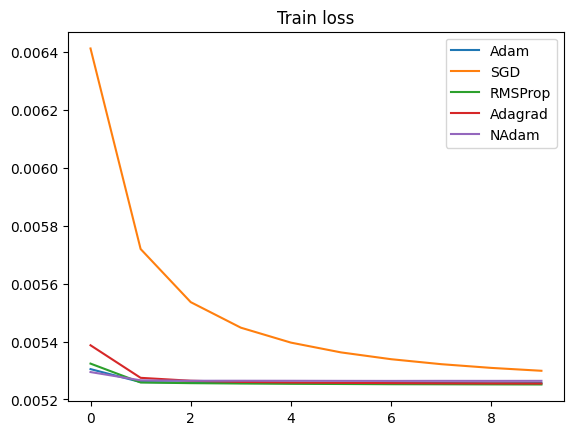

In [17]:
plt.plot(history_Adam['loss_train'], label='Adam')
plt.plot(history_SGD['loss_train'], label = 'SGD')
plt.plot(history_RMS['loss_train'], label = 'RMSProp')
plt.plot(history_Adagrad['loss_train'], label = 'Adagrad')
plt.plot(history_NAdam['loss_train'], label = 'NAdam')
plt.legend()
plt.title('Train loss')
plt.show()

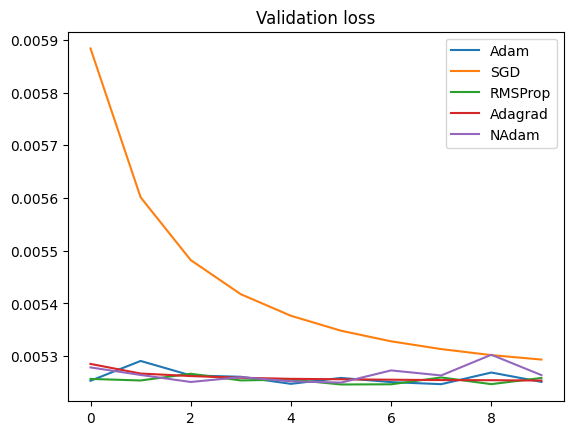

In [18]:
plt.plot(history_Adam['loss_val'], label='Adam')
plt.plot(history_SGD['loss_val'], label = 'SGD')
plt.plot(history_RMS['loss_val'], label = 'RMSProp')
plt.plot(history_Adagrad['loss_val'], label = 'Adagrad')
plt.plot(history_NAdam['loss_val'], label = 'NAdam')
plt.legend()
plt.title('Validation loss')
plt.show()

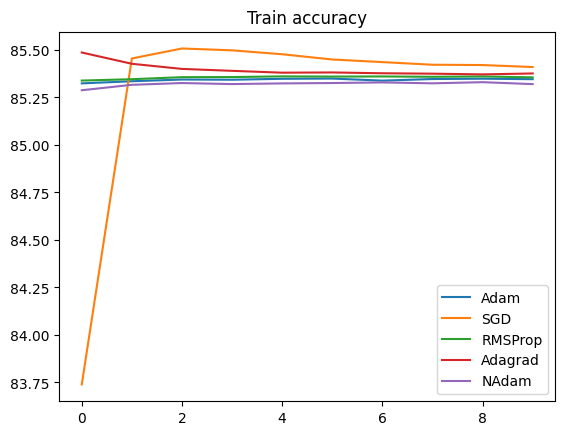

In [19]:
plt.plot(history_Adam['accuracy_train'], label='Adam')
plt.plot(history_SGD['accuracy_train'], label = 'SGD')
plt.plot(history_RMS['accuracy_train'], label = 'RMSProp')
plt.plot(history_Adagrad['accuracy_train'], label = 'Adagrad')
plt.plot(history_NAdam['accuracy_train'], label = 'NAdam')
plt.legend()
plt.title('Train accuracy')
plt.show()

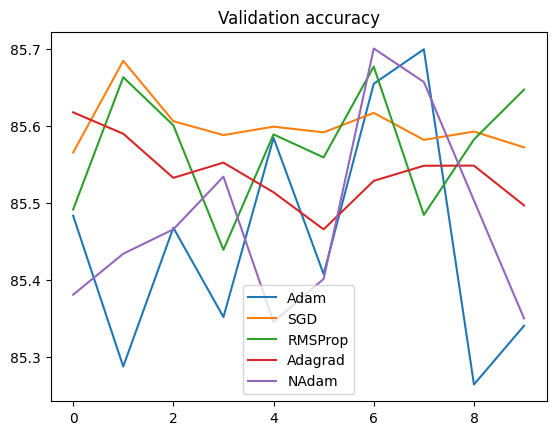

In [17]:
plt.plot(history_Adam['accuracy_val'], label='Adam')
plt.plot(history_SGD['accuracy_val'], label = 'SGD')
plt.plot(history_RMS['accuracy_val'], label = 'RMSProp')
plt.plot(history_Adagrad['accuracy_val'], label = 'Adagrad')
plt.plot(history_NAdam['accuracy_val'], label = 'NAdam')
plt.legend()
plt.title('Validation accuracy')
plt.show()

In [21]:
rmsProp = []
for lr in [0.001, 0.005, 0.01, 0.0005, 0.0001]:
    model = Net(50, 2)
    device = 'cpu'
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters())
    # optimizer = optim.SGD(model.parameters())
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    rmsProp.append(train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test'))

epoch: 1, training loss: 0.0052673736229227365, training accuracy: 85.39862087256333
epoch: 1, validation loss: 0.005224853781734147, validation accuracy: 85.44050666930704
model saved

epoch: 2, training loss: 0.005222634437125905, training accuracy: 85.40701940503028
epoch: 2, validation loss: 0.005224573018665425, validation accuracy: 85.290040595782
model saved

epoch: 3, training loss: 0.005216023249112236, training accuracy: 85.41868894487911
epoch: 3, validation loss: 0.005208374594535985, validation accuracy: 85.3841039930973
model saved

epoch: 4, training loss: 0.005212674372631607, training accuracy: 85.41767228042258
epoch: 4, validation loss: 0.005202956939822506, validation accuracy: 85.40231551550986
model saved

epoch: 5, training loss: 0.005210334302086294, training accuracy: 85.42452371480351
epoch: 5, validation loss: 0.005207810795269051, validation accuracy: 85.3418461886643

epoch: 6, training loss: 0.0052088450316932705, training accuracy: 85.4186005392742
epoch:

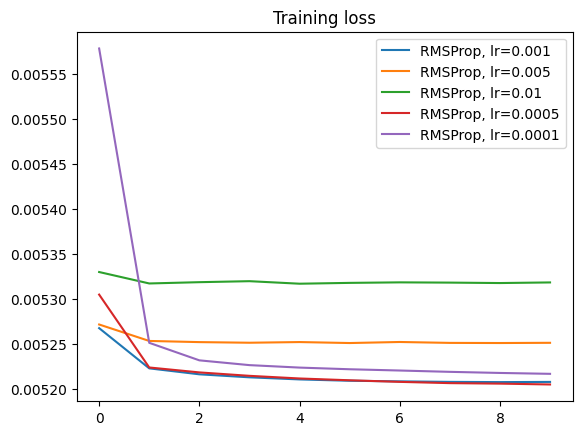

In [ ]:
lrs = [0.001, 0.005, 0.01, 0.0005, 0.0001]
for i in range(5):
    plt.plot(rmsProp[i]['loss_train'], label=f'RMSProp, lr={lrs[i]}')

plt.legend()
plt.title('Training loss')
plt.show()

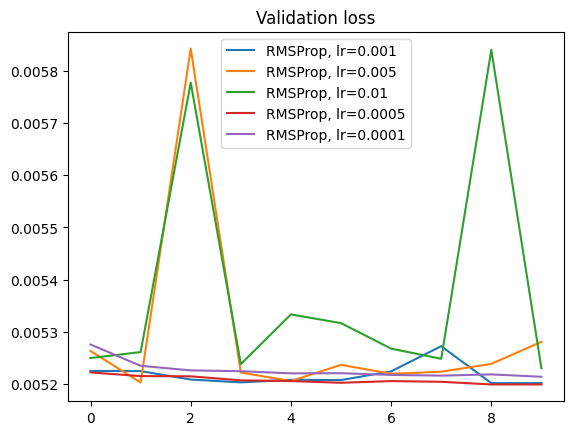

In [24]:
lrs = [0.001, 0.005, 0.01, 0.0005, 0.0001]
for i in range(5):
    plt.plot(rmsProp[i]['loss_val'], label=f'RMSProp, lr={lrs[i]}')
plt.legend()
plt.title('Validation loss')
plt.show()

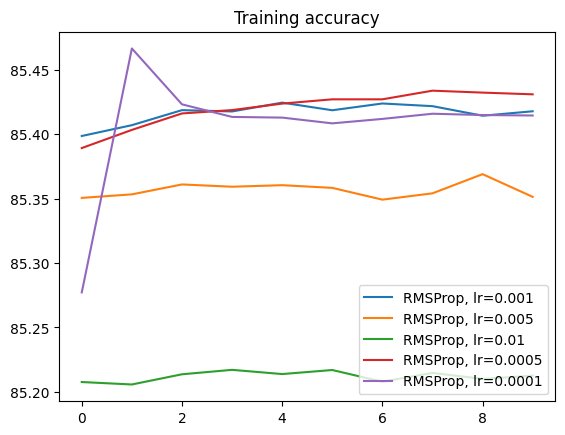

In [25]:
lrs = [0.001, 0.005, 0.01, 0.0005, 0.0001]
for i in range(5):
    plt.plot(rmsProp[i]['accuracy_train'], label=f'RMSProp, lr={lrs[i]}')
plt.legend()
plt.title('Training accuracy')
plt.show()

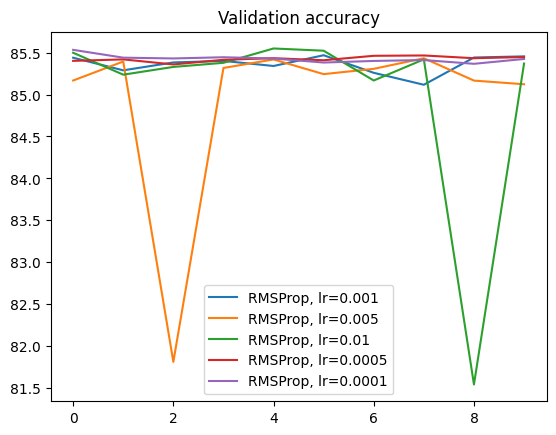

In [26]:
lrs = [0.001, 0.005, 0.01, 0.0005, 0.0001]
for i in range(5):
    plt.plot(rmsProp[i]['accuracy_val'], label=f'RMSProp, lr={lrs[i]}')
plt.legend()
plt.title('Validation accuracy')
plt.show()

In [27]:
sgd = []
for lr in [0.001, 0.005, 0.01, 0.0005, 0.0001]:
    model = Net(50, 2)
    device = 'cpu'
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    sgd.append(train(10, model, loader_train, loader_val, optimizer, criterion, device, model_path='test'))

epoch: 1, training loss: 0.006118090091694657, training accuracy: 84.38748176634398
epoch: 1, validation loss: 0.005636907358565146, validation accuracy: 85.49019053142283
model saved

epoch: 2, training loss: 0.0055168876315767204, training accuracy: 85.49370110064979
epoch: 2, validation loss: 0.005433466250715617, validation accuracy: 85.49054415321726
model saved

epoch: 3, training loss: 0.00539067780246855, training accuracy: 85.49091632409495
epoch: 3, validation loss: 0.005354625813629598, validation accuracy: 85.50928610832143
model saved

epoch: 4, training loss: 0.005334920006629744, training accuracy: 85.47266056667993
epoch: 4, validation loss: 0.005313993959737723, validation accuracy: 85.48400215002052
model saved

epoch: 5, training loss: 0.005303596865117526, training accuracy: 85.45453741767228
epoch: 5, validation loss: 0.005289559718386094, validation accuracy: 85.4415675346903
model saved

epoch: 6, training loss: 0.00528370988349623, training accuracy: 85.44216063

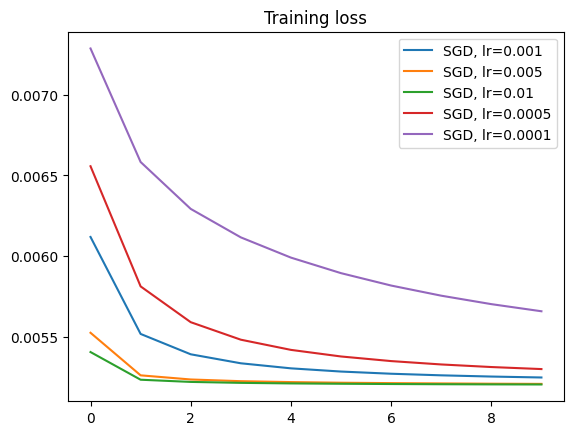

In [32]:
lrs = [0.001, 0.005, 0.01, 0.0005, 0.0001]
for i in range(5):
    plt.plot(sgd[i]['loss_train'], label=f'SGD, lr={lrs[i]}')

plt.legend()
plt.title('Training loss')
plt.show()

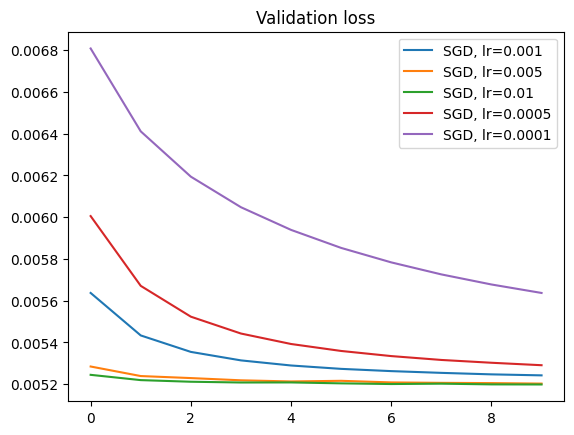

In [33]:
lrs = [0.001, 0.005, 0.01, 0.0005, 0.0001]
for i in range(5):
    plt.plot(sgd[i]['loss_val'], label=f'SGD, lr={lrs[i]}')
plt.legend()
plt.title('Validation loss')
plt.show()

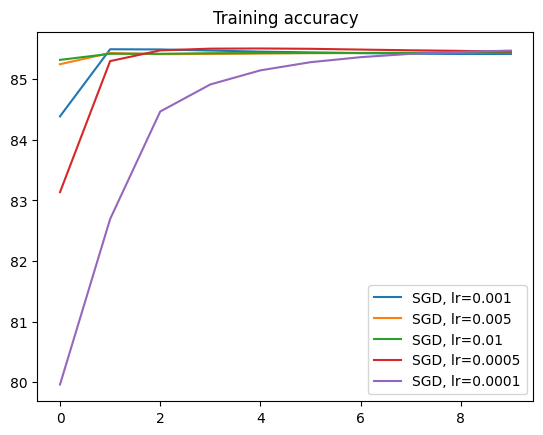

In [34]:
lrs = [0.001, 0.005, 0.01, 0.0005, 0.0001]
for i in range(5):
    plt.plot(sgd[i]['accuracy_train'], label=f'SGD, lr={lrs[i]}')
plt.legend()
plt.title('Training accuracy')
plt.show()

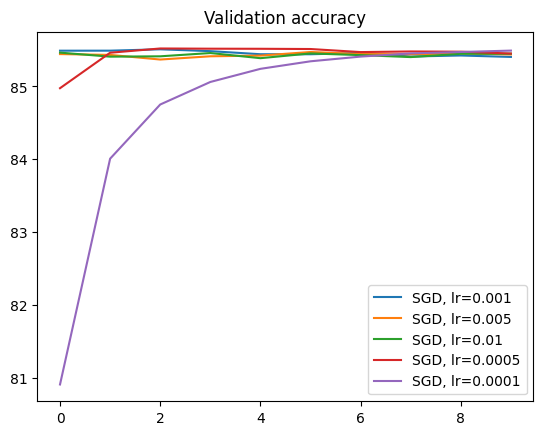

In [35]:
lrs = [0.001, 0.005, 0.01, 0.0005, 0.0001]
for i in range(5):
    plt.plot(sgd[i]['accuracy_val'], label=f'SGD, lr={lrs[i]}')
plt.legend()
plt.title('Validation accuracy')
plt.show()

In [1]:
np.sum(y)/len(y)

NameError: name 'np' is not defined